In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from scipy.stats import beta
from jax.scipy.special import betaln
from jax.scipy.special import gammaln
from jax.scipy.special import digamma
from numpy.random import multivariate_normal as mvn
from numpy.random import gamma
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
!pip install mycolorpy
from mycolorpy import colorlist as mcp
from scipy.stats import bernoulli

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=685322daad763af4fa89ed9449c530b3b4441144b8bce5c309467e58466dbd03
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [124]:
seed = 2015
key = random.PRNGKey(seed)

n = 1000
d = 2

In [125]:
# n of cluster and pi generation
K = 50

alpha = 5.0 #bigger alpha, more clusters
vi = beta.rvs(alpha, 1, size = K)

pi = np.cumprod(vi)

In [126]:
# Z generation

Z = np.zeros((n,K))

for i in range(0, n):
  for j in range(0, K):
    Z[i,j] = bernoulli.rvs(pi[j])

In [127]:
# A generation

A = np.zeros((K,d))
sigma2a = 5.0
Id = np.eye(d)
mu0 = np.zeros(d)

for i in range(0, K):
  A[i] = mvn(mu0, sigma2a*Id)

In [128]:
# Finally X
X=np.zeros((n,d))
sigma2x=1.0
for i in range(n):
  X[i,:] = mvn(jnp.matmul(Z[i,:],A),sigma2x*Id)

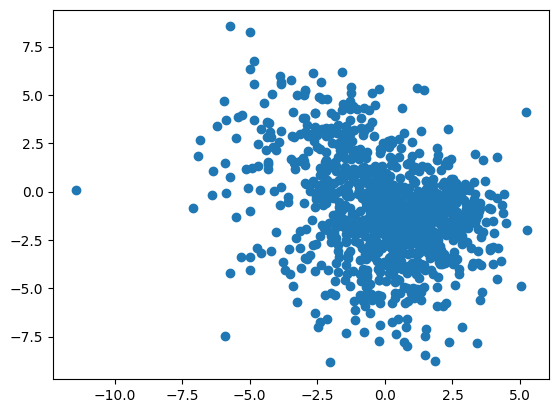

In [129]:
x = X[:,0]
y = X[:,1]

plt.scatter(x, y)
plt.show()

In [130]:
def update_tau(nu,alpha,multinomial_q):
  '''
  Function for the updates of the variational parameter tau, the beta distribution parameters of pi_k in the variational distribution
  Let K the number of features, then
  Inputs:
    - nu: (N,K) matrix, variational representing the feature allocation probabilities
    - alpha: hyperparamter of the model for the distribution of the v_i
    - multinomial_q: (K,K) matrix, each row is the multinomial distribution q_k introduced for the lower bound of the expected value of log(1-prod(v_i))
  Output:
    - updated_tau: (K,2) matrix for the updated variational parameters tau
  '''
  K=nu.shape[1]
  N=nu.shape[0]
  # create the matrix
  updated_tau=jnp.zeros((K,2),dtype=jnp.float64)
  # computation of useful quantities
  nu_sum=jnp.sum(nu,axis=0)
  nu_sum_inv=nu_sum[::-1]
  nu_cumsum_inv=jnp.cumsum(nu_sum_inv)
  nu_cumsum=nu_cumsum_inv[::-1]
  nu_sum_cumsum=jnp.cumsum(nu_sum)
  q_cumsum=jnp.cumsum(multinomial_q,axis=1)
  # computation of updated variational parameters
  updated_tau=updated_tau.at[:,0].set(alpha+nu_cumsum + (N-nu_sum) @ (1-q_cumsum))
  updated_tau=updated_tau.at[:,1].set(1+ (N-jnp.sum(nu,axis=0)) @ multinomial_q)

  return updated_tau

update_tau_jit=jit(update_tau)

def update_nu(data,tau,phi_means,phi_variances,nu,sigma2x,alpha,multinomial_q):
  '''
  Function for the updated of the variational parameter nu, feature allocation probabilities in variational distribution
  Let K the number of features, N the number of samples and d the dimension of the samples, then
  Inputs:
    - data: (N,d) matrix for the samples
    - tau: (K,2) matrix for the variational parameters tau, the beta distribution parameters of pi_k in the variational distribution
    - phi_means: (K,d) matrix for the variational parameters representing the means of the features
    - phi_variances: K vector for the variational parameters representing the variances of the features, each feature k has a variance phi_variances[k]*np.eye(d)
    - nu: (N,K) matrix, variational representing the feature allocation probabilities
    - sigma2x: hyperparameter of the model representing the measurement error variance of the samples
    - alpha: hyperparamter of the model for the distribution of the v_i
    - multinomial_q: (K,K) matrix, each row is the multinomial distribution q_k introduced for the lower bound of the expected value of log(1-prod(v_i))
  Output:
    - updated_nu: (N,K) matrix of the updated variational parameters nu
  '''
  N=data.shape[0]
  K=phi_means.shape[0]
  d=data.shape[1]
  # create the matrix
  log_likelihood=jnp.zeros((N,K),dtype=jnp.float64)
  updated_nu=jnp.zeros((N,K),dtype=jnp.float64)
  # computation of useful quantities
  digamma_cumsum=jnp.cumsum(digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1]))
  q_mat_cumsum=jnp.cumsum(multinomial_q,axis=1)
  q_mat_cumsum_tril_tot=jnp.tril(q_mat_cumsum,k=0)
  q_mat_cumsum_tril=jnp.tril(q_mat_cumsum,k=-1)
  # computation of log_likelihood
  log_likelihood=1/sigma2x*(data @ phi_means.T - ((nu @ phi_means) @ phi_means.T - nu*jnp.resize(jnp.diag(phi_means @ phi_means.T),(K))))
  log_likelihood=log_likelihood.at[:,:].add(-0.5/sigma2x*jnp.resize(d*phi_variances,(K,)))
  log_likelihood=log_likelihood.at[:,:].add(-0.5/sigma2x*jnp.resize(jnp.diag(phi_means @ phi_means.T),(K,)))
  log_likelihood=log_likelihood.at[:,:].add(digamma_cumsum + jnp.sum(multinomial_q*jnp.log(multinomial_q),axis=1))
  log_likelihood=log_likelihood.at[:,:].add(-(multinomial_q @ digamma(tau[:,1])) + jnp.cumsum(digamma(tau[:,0]+tau[:,1])))
  log_likelihood=log_likelihood.at[:,1:].add(-(jnp.cumsum(digamma(tau[:-1,0]))) + q_mat_cumsum_tril_tot[1:,:-1] @ digamma(tau[:-1,0]) - ( q_mat_cumsum_tril[1:,:-1] @ digamma(tau[1:,0]+tau[1:,1])))
  # computation of updated parameters
  updated_nu=1/(1+jnp.exp(-log_likelihood))
  # we have both nu*log(nu) and (1-nu)*log(1-nu), so we can't have exact zeros or ones or we will have nan, thanks to the fact that x*log(x) tends to 0 as x tends to 0 it doesn't change so much the elbow
  updated_nu=updated_nu.at[:,:].max(10**(-307))
  updated_nu=updated_nu.at[:,:].min(1-10**(-5))
  return updated_nu

update_nu_jit=jit(update_nu)

def update_phi(data,nu,sigma2a,sigma2x,phi_means):
  '''
  Function for the update of the variational parameters phi_means and phi_variances, the feature means and variances in the variational distribution
  Let N the number of samples, K the number of feature and d the dimension of the samples, then
  Inputs:
    - data: (N,d) matrix for the samples
    - nu: (N,K) matrix, variational representing the feature allocation probabilities
    - sigma2a: hyperparameter of the model representing the variance of the features
    - sigma2x: hyperparameter of the model representing the measurement error variance of the samples
    - phi_means: (K,d) matrix for the variational parameters representing the means of the features
  Outputs:
    - updated_phi_means: (K,d) matrix for the updated variational parameters representing the means of the features
    - updated_phi_variances: K vector for the updated variational parameters representing the variances of the features, each feaure k will have variance phi_variances[k]*np.eye(d)
  '''
  N=data.shape[0]
  d=data.shape[1]
  K=nu.shape[1]
  # create the matrices
  updated_phi_means=jnp.zeros((K,d),dtype=jnp.float64)
  updated_phi_variances=jnp.zeros((K,),dtype=jnp.float64)
  # computation of updates
  updated_phi_variances=1/(jnp.sum(nu,axis=0)/sigma2x+1/sigma2a)
  updated_phi_means= (nu.T @ data-(nu.T @ (nu @ phi_means))+jnp.sum(nu**2,axis=0)[:,None]*phi_means)/sigma2x*updated_phi_variances[:,None]
  return updated_phi_means,updated_phi_variances

update_phi_jit=jit(update_phi)

def update_q(tau):
  '''
  Function for the update of multinomial distribution q, used fo rthe lower bound of the expected value of log(1-prod(v_i))
  Let K the number of features, then
  Input:
    - tau: (K,2) matrix, variational parameters for the parameters of beta distribution of pi is the variational distribution
  Output:
    - updated_multi_q_matrix: (K,K) matrix for the K multinomial distributions, each row represents the parameters of q_k
  '''
  K=tau.shape[0]
  # create the vector of probabilities
  updated_multi_q=jnp.zeros((K,),dtype=jnp.float64)
  # computation of useful quantities and vector
  digamma_cumsum=jnp.cumsum(digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1]))
  updated_multi_q=jnp.exp(digamma(tau[:,1])-digamma(tau[:,0])+digamma_cumsum)
  updated_multi_q=jnp.nan_to_num(updated_multi_q, nan=10**-10, posinf=jnp.float64(10**308/K))
  # creating the matrix as a copy of K equal vectors updated_multi_q
  updated_multi_q_matrix=jnp.tile(updated_multi_q,(K,1))
  # making the matrix upper triangular so the probability q_k(y) is 0 for y>k
  updated_multi_q_matrix=jnp.tril(updated_multi_q_matrix)
  # normalizing with respect to the rows, each row is a probability vector
  updated_multi_q_matrix/=jnp.sum(updated_multi_q_matrix,axis=1,keepdims=True)
  # we have qlog(q), so we can't have exact zeros but still it tends to 0 as wanted
  updated_multi_q_matrix=updated_multi_q_matrix.at[:,:].max(10**-307)

  return updated_multi_q_matrix

update_q_jit=jit(update_q)

In [118]:
def compute_ELBO(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha,multinomial_q):
  '''
  Function for the computation of the ELBO
  Let N the number of samples, K the number of features and d the dimension of the samples, then
  Inputs:
    - data: (N,d) matrix for the samples
    - phi_means: (K,d) matrix for the variational parameters representing the means of the features
    - phi_variances: K vector for the variational parameters representing the variances of the features, each feature k has a variance phi_variances[k]*np.eye(d)
    - tau: (K,2) matrix for the variational parameters tau, the beta distribution parameters of pi_k in the variational distribution
    - nu: (N,K) matrix, variational representing the feature allocation probabilities
    - sigma2a: hyperparameter of the model representing the variance of the features
    - sigma2x: hyperparameter of the model representing the measurement error variance of the samples
    - alpha: hyperparamter of the model for the distribution of the v_i
    - multinomial_q: (K,K) matrix, each row is the multinomial distribution q_k introduced for the lower bound of the expected value of log(1-prod(v_i))
  Output:
    - value of the ELBO given the above inputs
  '''
  K=phi_means.shape[0]
  d=data.shape[1]
  N=data.shape[0]

  # computation of first term
  T1=jnp.sum(betaln(tau[:,0],tau[:,1]))+jnp.sum(-(tau[:,0]-1)*digamma(tau[:,0])-(tau[:,1]-1)*digamma(tau[:,1])+(tau[:,0]+tau[:,1]-2)*digamma(tau[:,0]+tau[:,1]))
  T1+= d/2*jnp.sum(jnp.log(phi_variances))
  T1+= jnp.sum(-nu*jnp.log(nu)-(1-nu)*jnp.log(1-nu))

  # computation of second term
  T2=(alpha-1)*jnp.sum(digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1]))

  # computation of third term
  T3 = -0.5/sigma2a*((jnp.sum(d*phi_variances)) + jnp.sum(jnp.diag(phi_means @ phi_means.T)))

  # computation of fourth term
  digamma_cumsum=jnp.cumsum(digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1]))
  T4 = jnp.sum(nu @ digamma_cumsum) - jnp.sum( (1-nu) @ jnp.sum(multinomial_q*jnp.log(multinomial_q),axis=1))
  q_mat_cumsum=jnp.cumsum(multinomial_q,axis=1)
  q_mat_cumsum_tril_tot=jnp.tril(q_mat_cumsum,k=0)
  q_mat_cumsum_tril=jnp.tril(q_mat_cumsum,k=-1)
  T4 += (N-jnp.sum(nu,axis=0)) @ (multinomial_q @ digamma(tau[:,1])) + (N-1-jnp.sum(nu[:,1:],axis=0)) @ (jnp.cumsum(digamma(tau[:-1,0])) - q_mat_cumsum_tril_tot[1:,:-1] @ digamma(tau[:-1,0]))
  T4 += -(N-jnp.sum(nu,axis=0)) @ jnp.cumsum(digamma(tau[:,0]+tau[:,1])) + (N-1-jnp.sum(nu[:,1:],axis=0)) @ ( q_mat_cumsum_tril[1:,:-1] @ digamma(tau[1:,0]+tau[1:,1]))

  # computation of the fifth term
  T5 = -0.5/sigma2x*(-2*jnp.sum(jnp.diag((nu @ phi_means) @ data.T))+ jnp.sum(nu @ (d*phi_variances + jnp.diag(phi_means @ phi_means.T))))
  T5 += -0.5/sigma2x*( jnp.sum(jnp.diag((nu @ phi_means) @ (nu @ phi_means).T)) - jnp.sum( nu**2 @ jnp.diag(phi_means @ phi_means.T)))

  return T1+T2+T3+T4+T5

compute_ELBO_jit=jit(compute_ELBO)

In [119]:
def single_iteration_VI(data,K,i,nMax,tol,sigma2a,sigma2x,alpha):
  '''
  Function for a single application of Variational Inference algorithm with respect to the inizializations, It generated random starting parameters and then applies the algorithm
  Let N the number of samples and d the dimension of the samples, then
  Inputs:
    - data: (N,d) matrix of samples
    - K: maximum number of features to approximate
    - i: scalar, needed for the seed of the random initialization, different is led to different seeds
    - nMax: scalar for the maximum number of iterations in the VI algorithm
    - tol: tolerance of the algorithm, if the ELBO doesn't improve more than the tolerance, the algorithm stops
    - sigma2a: hyperparameter of the model representing the variance of the features
    - sigma2x: hyperparameter of the model representing the measurement error variance of the samples
    - alpha: hyperparamter of the model for the distribution of the v_i
  Outputs:
    - phi_means: (K,d) matrix for the variational parameters representing the means of the features
    - phi_variances: K vector for the variational parameters representing the variances of the features, each feature k has a variance phi_variances[k]*np.eye(d)
    - tau: (K,2) matrix for the variational parameters tau, the beta distribution parameters of pi_k in the variational distribution
    - nu: (N,K) matrix, variational representing the feature allocation probabilities
    - multinomial_q: (K,K) matrix, each row is the multinomial distribution q_k introduced for the lower bound of the expected value of log(1-prod(v_i))
  '''

  # initialize the parameters
  N=data.shape[0]
  d=data.shape[1]
  key = random.PRNGKey(i*seed)
  # random initialization of the variational parameters
  phi_means=random.normal(key,shape=(K,d))*jnp.sqrt(sigma2a)
  phi_variances= random.gamma(key,a=5.0,shape=(K,),dtype=jnp.float64)
  tau=jnp.array(random.geometric(key,0.01,(K,2)),dtype=jnp.float64)
  nu=random.beta(key,5,5,shape=(N,K),dtype=jnp.float64)
  nu=jnp.cumprod(nu,axis=1)
  multinomial_q_vec=random.uniform(key,shape=(K,),dtype=jnp.float64)
  multinomial_q=jnp.tile(multinomial_q_vec,(K,1))
  multinomial_q=jnp.tril(multinomial_q)
  multinomial_q/=jnp.sum(multinomial_q,axis=1,keepdims=True)
  multinomial_q=multinomial_q.at[:,:].max(10**-307)
  improvement=1
  ELBO_new= compute_ELBO_jit(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha,multinomial_q)
  ELBO_old=ELBO_new-1
  nit=0

  # codition funztion for the while loop
  def cond(state):
    _,_,_,_,_,_,_,_,nit,_,improvement,tol,nMax,_=state
    return (((improvement>tol) & (nit<nMax)))

  # body function for the while loop
  def iteration_while(state):
    data,tau,nu,phi_variances,phi_means,sigma2a,sigma2x,alpha,nit,ELBO_new,improvement,tol,nMax,multinomial_q=state
    phi_means_old=jnp.copy(phi_means)
    phi_variances_old=jnp.copy(phi_variances)
    tau_old=jnp.copy(tau)
    nu_old=jnp.copy(nu)
    multinomial_q_old=jnp.copy(multinomial_q)
    # update of variational parameters
    phi_means,phi_variances=update_phi_jit(data,nu_old,sigma2a,sigma2x,phi_means_old)
    tau=update_tau_jit(nu_old,alpha,multinomial_q_old)
    nu=update_nu_jit(data,tau_old,phi_means_old,phi_variances_old,nu_old,sigma2x,alpha,multinomial_q_old)
    multinomial_q=update_q_jit(tau_old)
    ELBO_old=ELBO_new
    # computation of ELBO and imporvement
    ELBO_new=compute_ELBO_jit(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha,multinomial_q)
    improvement=ELBO_new-ELBO_old
    nit+=1
    return (data,tau,nu,phi_variances,phi_means,sigma2a,sigma2x,alpha,nit,ELBO_new,improvement,tol,nMax,multinomial_q)

  state=(data,tau,nu,phi_variances,phi_means,sigma2a,sigma2x,alpha,nit,ELBO_new,improvement,tol,nMax,multinomial_q)
  _,tau,nu,phi_variances,phi_means,_,_,_,nit,ELBO_new,_,_,_,multinomial_q=jax.lax.while_loop(cond_fun=cond,body_fun=iteration_while,init_val=state)

  return  tau,phi_means,phi_variances,nu,ELBO_new,nit,multinomial_q

single_iteration_VI_jit=jit(single_iteration_VI,static_argnames=['K'])

In [120]:
def VI(data,K,nMax,n_iniz,tol,sigma2a,sigma2x,alpha):
  '''
  Function for application of variational inference algortihm to as many as wanted different initializations
  Let N the number of samples and d the dimension of a sample, then
  Inputs:
    - data: (N,d) matrix of samples
    - K: maximum number of features to approximate
    - nMax: scalar for the maximum number of iterations in the VI algorithm
    - tol: tolerance of the algorithm, if the ELBO doesn't improve more than the tolerance, the algorithm stops
    - n_iniz: number or random different initializations from which the VI algorithm will start
    - sigma2a: hyperparameter of the model representing the variance of the features
    - sigma2x: hyperparameter of the model representing the measurement error variance of the samples
    - alpha: hyperparamter of the model for the distribution of the v_i
  Outputs:
    - phi_means: (K,d) matrix for the variational parameters representing the means of the features
    - phi_variances: K vector for the variational parameters representing the variances of the features, each feature k has a variance phi_variances[k]*np.eye(d)
    - tau: (K,2) matrix for the variational parameters tau, the beta distribution parameters of pi_k in the variational distribution
    - nu: (N,K) matrix, variational representing the feature allocation probabilities
    - multinomial_q: (K,K) matrix, each row is the multinomial distribution q_k introduced for the lower bound of the expected value of log(1-prod(v_i))
  All the parameters returned are the ones of the iteration that has reached the highest value of the ELBO
  '''
  ELBO_max=0
  for i in range(n_iniz):
    # every iteration we call the algorithm function, then if the ELBO is better than the one before we save it, otherwise we simply go on
    tau,phi_means,phi_variances,nu,ELBO_new,nit,multinomial_q=single_iteration_VI_jit(data,K,i,nMax,tol,sigma2a,sigma2x,alpha)
    if i==0:
      ELBO_max=ELBO_new
      phi_means_max=phi_means
      phi_variances_max=phi_variances
      tau_max=tau
      nu_max=nu
      multi_q_max=multinomial_q
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      phi_means_max=phi_means
      phi_variances_max=phi_variances
      tau_max=tau
      nu_max=nu
      multi_q_max=multinomial_q
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return tau,phi_means,phi_variances,nu,multi_q_max


In [131]:
nMax=1000
n_iniz=100
tol=10**-6
K=50
tau,means,variances,nu,multi_q=VI(X,K,nMax,n_iniz,tol,sigma2a,sigma2x,alpha)

Initialization number:  1 	 ELBO:  -512709.15889423655 	 N_iterations:  1

Initialization number:  2 	 ELBO:  -22442243.09552151 	 N_iterations:  2

Initialization number:  3 	 ELBO:  -12854857.872892046 	 N_iterations:  2

Initialization number:  4 	 ELBO:  -2256874.149441379 	 N_iterations:  2

Initialization number:  5 	 ELBO:  -1527116.3820296982 	 N_iterations:  2

Initialization number:  6 	 ELBO:  -1128279.1446288954 	 N_iterations:  2

Initialization number:  7 	 ELBO:  -14714281.69881947 	 N_iterations:  2

Initialization number:  8 	 ELBO:  -18928745.73807559 	 N_iterations:  2

Initialization number:  9 	 ELBO:  -25291365.518386673 	 N_iterations:  2

Initialization number:  10 	 ELBO:  -8416219.180116769 	 N_iterations:  2

Initialization number:  11 	 ELBO:  -10114259.935450738 	 N_iterations:  2

Initialization number:  12 	 ELBO:  -6024048.74454988 	 N_iterations:  2

Initialization number:  13 	 ELBO:  -5787727.148909918 	 N_iterations:  2

Initialization number:  14 	 

In [132]:
jnp.floor(jnp.sum(nu,axis=0))

Array([117., 593., 432., 415., 384., 407., 367., 484., 379., 405., 447.,
       605., 627., 809., 938., 980., 989., 991., 991., 990., 990., 989.,
       988., 986., 985., 978., 973., 968., 965., 964., 956., 948., 931.,
       900., 871., 793., 780., 690., 690., 543., 346., 196., 146., 116.,
        69.,  55.,   4.,   3.,   1.,   0.], dtype=float64)

In [88]:
jnp.sum(Z,axis=0)

Array([706., 616., 576., 572., 590., 370., 391., 354., 259., 249., 203.,
       225., 196., 102., 116.,  85.,  76.,  66.,  66.,  63.,  65.,  49.,
        56.,  40.,  51.,  29.,  29.,  20.,   8.,  14.,   7.,  13.,   6.,
         4.,   4.,   1.,   1.,   2.,   3.,   1.,   3.,   1.,   4.,   2.,
         0.,   2.,   0.,   0.,   1.,   0.], dtype=float64)